<a href="https://colab.research.google.com/github/xiximitho/AgenteReativoSimples/blob/main/Reconhecimento_placa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
#import pytesseract as pt
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet

from glob import glob
from skimage import io
from shutil import copy

Analise dos dados do XML (imagens anotadas pelo labelMG) para conversão em CSV

In [ ]:
path = glob('/content/drive/MyDrive/images/*.xml')
labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])
for filename in path:

    info = xet.parse(filename)
    root = info.getroot()
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    labels_dict['filepath'].append(filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

No código acima, cada informação referente ao xmin, xmax, ymin e ymax foram obtidas do XML gerado. 

In [ ]:
df = pd.DataFrame(labels_dict)
df.to_csv('labels.csv',index=False)
df.head()

filepath  xmin  xmax  ymin  ymax
0  /content/drive/MyDrive/images/N102.xml   164   316   216   243
1  /content/drive/MyDrive/images/N105.xml   360   434   174   195
2  /content/drive/MyDrive/images/N120.xml   647   736   332   387
3  /content/drive/MyDrive/images/N122.xml   342   494   243   288
4  /content/drive/MyDrive/images/N123.xml    11   246    78   165

Criação do CSV a partir das posições das placas obtidas

In [ ]:
filename = df['filepath'][0]
def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join('/content/drive/MyDrive/images',filename_image)
    return filepath_image
    
getFilename(filename)

'/content/drive/MyDrive/images/N102.jpeg'

Função para retornar o nome do arquivo.

In [ ]:
image_path = list(df['filepath'].apply(getFilename))
image_path[:10]#random check

['/content/drive/MyDrive/images/N102.jpeg',
 '/content/drive/MyDrive/images/N105.jpeg',
 '/content/drive/MyDrive/images/N120.jpeg',
 '/content/drive/MyDrive/images/N122.jpeg',
 '/content/drive/MyDrive/images/N123.jpeg',
 '/content/drive/MyDrive/images/N100.jpeg',
 '/content/drive/MyDrive/images/N113.jpeg',
 '/content/drive/MyDrive/images/N103.jpeg',
 '/content/drive/MyDrive/images/N108.jpeg',
 '/content/drive/MyDrive/images/N121.jpeg']

Verificando os dados


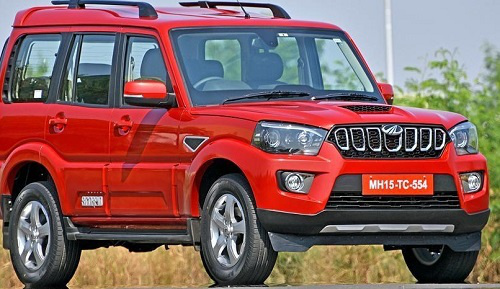

In [ ]:
file_path = image_path[1] #Caminho da imagem N105
img = cv2.imread(file_path) #Leitura da imagem
# xmin-360/ymin-174/xmax-434/ymax-195 
img = io.imread(file_path) #Leitura da imagem
fig = px.imshow(img)
fig.update_layout(width=600, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figura 1 - N105.jpeg com o retangulo na placa')
fig.add_shape(type='rect',x0=360, x1=434, y0=174, y1=195, xref='x', yref='y',line_color='cyan')

In [ ]:
# parsing
def parsing(path):
    parser = xet.parse(path).getroot()
    name = parser.find('filename').text
    filename = f'/content/drive/MyDrive/images/{name}'

    # width and height
    parser_size = parser.find('size')
    width = int(parser_size.find('width').text)
    height = int(parser_size.find('height').text)
    
    return filename, width, height
df[['filename','width','height']] = df['filepath'].apply(parsing).apply(pd.Series)
df.head()

filepath  xmin  xmax  ymin  ymax  \
0  /content/drive/MyDrive/images/N102.xml   164   316   216   243   
1  /content/drive/MyDrive/images/N105.xml   360   434   174   195   
2  /content/drive/MyDrive/images/N120.xml   647   736   332   387   
3  /content/drive/MyDrive/images/N122.xml   342   494   243   288   
4  /content/drive/MyDrive/images/N123.xml    11   246    78   165   

                                  filename  width  height  
0  /content/drive/MyDrive/images/N102.jpeg    478     395  
1  /content/drive/MyDrive/images/N105.jpeg    500     289  
2  /content/drive/MyDrive/images/N120.jpeg    800     485  
3  /content/drive/MyDrive/images/N122.jpeg    600     398  
4  /content/drive/MyDrive/images/N123.jpeg    250     250

Obtenção da altura e largura da imagem, para calcular o centro X/Y da placa.

In [ ]:
# center_x, center_y, width , height
df['center_x'] = (df['xmax'] + df['xmin'])/(2*df['width'])
df['center_y'] = (df['ymax'] + df['ymin'])/(2*df['height'])

df['bb_width'] = (df['xmax'] - df['xmin'])/df['width']
df['bb_height'] = (df['ymax'] - df['ymin'])/df['height']
df.head()

filepath  xmin  xmax  ymin  ymax  \
0  /content/drive/MyDrive/images/N102.xml   164   316   216   243   
1  /content/drive/MyDrive/images/N105.xml   360   434   174   195   
2  /content/drive/MyDrive/images/N120.xml   647   736   332   387   
3  /content/drive/MyDrive/images/N122.xml   342   494   243   288   
4  /content/drive/MyDrive/images/N123.xml    11   246    78   165   

                                  filename  width  height  center_x  center_y  \
0  /content/drive/MyDrive/images/N102.jpeg    478     395  0.502092  0.581013   
1  /content/drive/MyDrive/images/N105.jpeg    500     289  0.794000  0.638408   
2  /content/drive/MyDrive/images/N120.jpeg    800     485  0.864375  0.741237   
3  /content/drive/MyDrive/images/N122.jpeg    600     398  0.696667  0.667085   
4  /content/drive/MyDrive/images/N123.jpeg    250     250  0.514000  0.486000   

   bb_width  bb_height  
0  0.317992   0.068354  
1  0.148000   0.072664  
2  0.111250   0.113402  
3  0.253333   0.113065  
4  0.940000   0.348000

Preparação dos dados para treinamento do YOLO <br>
!git clone https://github.com/ultralytics/yolov5

In [ ]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 15393, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 15393 (delta 9), reused 17 (delta 6), pack-reused 15369
Receiving objects: 100% (15393/15393), 14.37 MiB | 6.99 MiB/s, done.
Resolving deltas: 100% (10522/10522), done.


In [ ]:
!pip install -r ./yolov5/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.4 MB/s eta 0:00:00


Criação dos diretórios para treinamento

In [ ]:
!mkdir ./yolov5/data_images/
!mkdir ./yolov5/data_images/test/
!mkdir ./yolov5/data_images/train/

Separação dos dados para treino e teste.

In [ ]:
df_train = df.iloc[:200]
df_test = df.iloc[200:]

Cada arquivo será copiado para o diretório de treino e teste, gerando um .txt com as informações das anotações.

In [ ]:
train_folder = './yolov5/data_images/train'

values = df_train[['filename','center_x','center_y','bb_width','bb_height']].values
for fname, x,y, w, h in values:
    image_name = os.path.split(fname)[-1]
    txt_name = os.path.splitext(image_name)[0]
    
    dst_image_path = os.path.join(train_folder,image_name)
    dst_label_file = os.path.join(train_folder,txt_name+'.txt')
    
    # copy each image into the folder
    copy(fname,dst_image_path)

    # generate .txt which has label info
    label_txt = f'0 {x} {y} {w} {h}'
    with open(dst_label_file,mode='w') as f:
        f.write(label_txt)
        
        f.close()

test_folder = './yolov5/data_images/test'

values = df_test[['filename','center_x','center_y','bb_width','bb_height']].values
for fname, x,y, w, h in values:
    image_name = os.path.split(fname)[-1]
    txt_name = os.path.splitext(image_name)[0]
    
    dst_image_path = os.path.join(test_folder,image_name)
    dst_label_file = os.path.join(test_folder,txt_name+'.txt')
    
    # copy each image into the folder
    copy(fname,dst_image_path)

    # generate .txt which has label info
    label_txt = f'0 {x} {y} {w} {h}'
    with open(dst_label_file,mode='w') as f:
        f.write(label_txt)
        
        f.close()

Criação do arquivo data.yaml com o caminho do treino e a validação, com o numero de classes.


```yaml
train: data_images/train
val: data_images/test
nc: 1
names: [
    'license_plate'
]
```



Treinando o YOLO (collab deve estar em ambiente com GPU)

In [ ]:
!pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()  

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7408 sha256=217d12dea1ba7b74ba01ce2699955a093aa66aa87657e517be8ae48656276bc8
  Stored in directory: /root/.cache/pip/wheels/2b/b5/24/fbb56595c286984f7315ee31821d6121e1b9828436021a88b3
Successfully built GPUtil
Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  5% |  1% |


In [ ]:
!python ./yolov5/train.py --data ./data.yaml --cfg ./yolov5/models/yolov5s.yaml --batch-size 8 --name Model --epochs 100

train: weights=yolov5/yolov5s.pt, cfg=./yolov5/models/yolov5s.yaml, data=./data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=Model, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-140-g1db9533 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0,

Após o treino do YOLOv5 estar concluido, vamos converter o arquivo gerado para DNN para ser utilizada com opencv. Em seguida analisar a predição dos resultados

In [ ]:
!python yolov5/export.py --weights ./yolov5/runs/train/Model2/weights/best.pt --include onnx --simplify

export: data=yolov5/data/coco128.yaml, weights=['./yolov5/runs/train/Model2/weights/best.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=True, opset=17, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['onnx']
YOLOv5 🚀 v7.0-140-g1db9533 Python-3.9.16 torch-2.0.0+cu118 CPU

Traceback (most recent call last):
  File "/content/yolov5/export.py", line 672, in <module>
    main(opt)
  File "/content/yolov5/export.py", line 667, in main
    run(**vars(opt))
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/_contextlib.py", line 115, in decorate_context
    return func(*args, **kwargs)
  File "/content/yolov5/export.py", line 547, in run
    model = attempt_load(weights, device=device, inplace=True, fuse=True)  # load FP32 model
  File "/content/yolov5/models/experimental.py", line 79, in attempt_load
    c


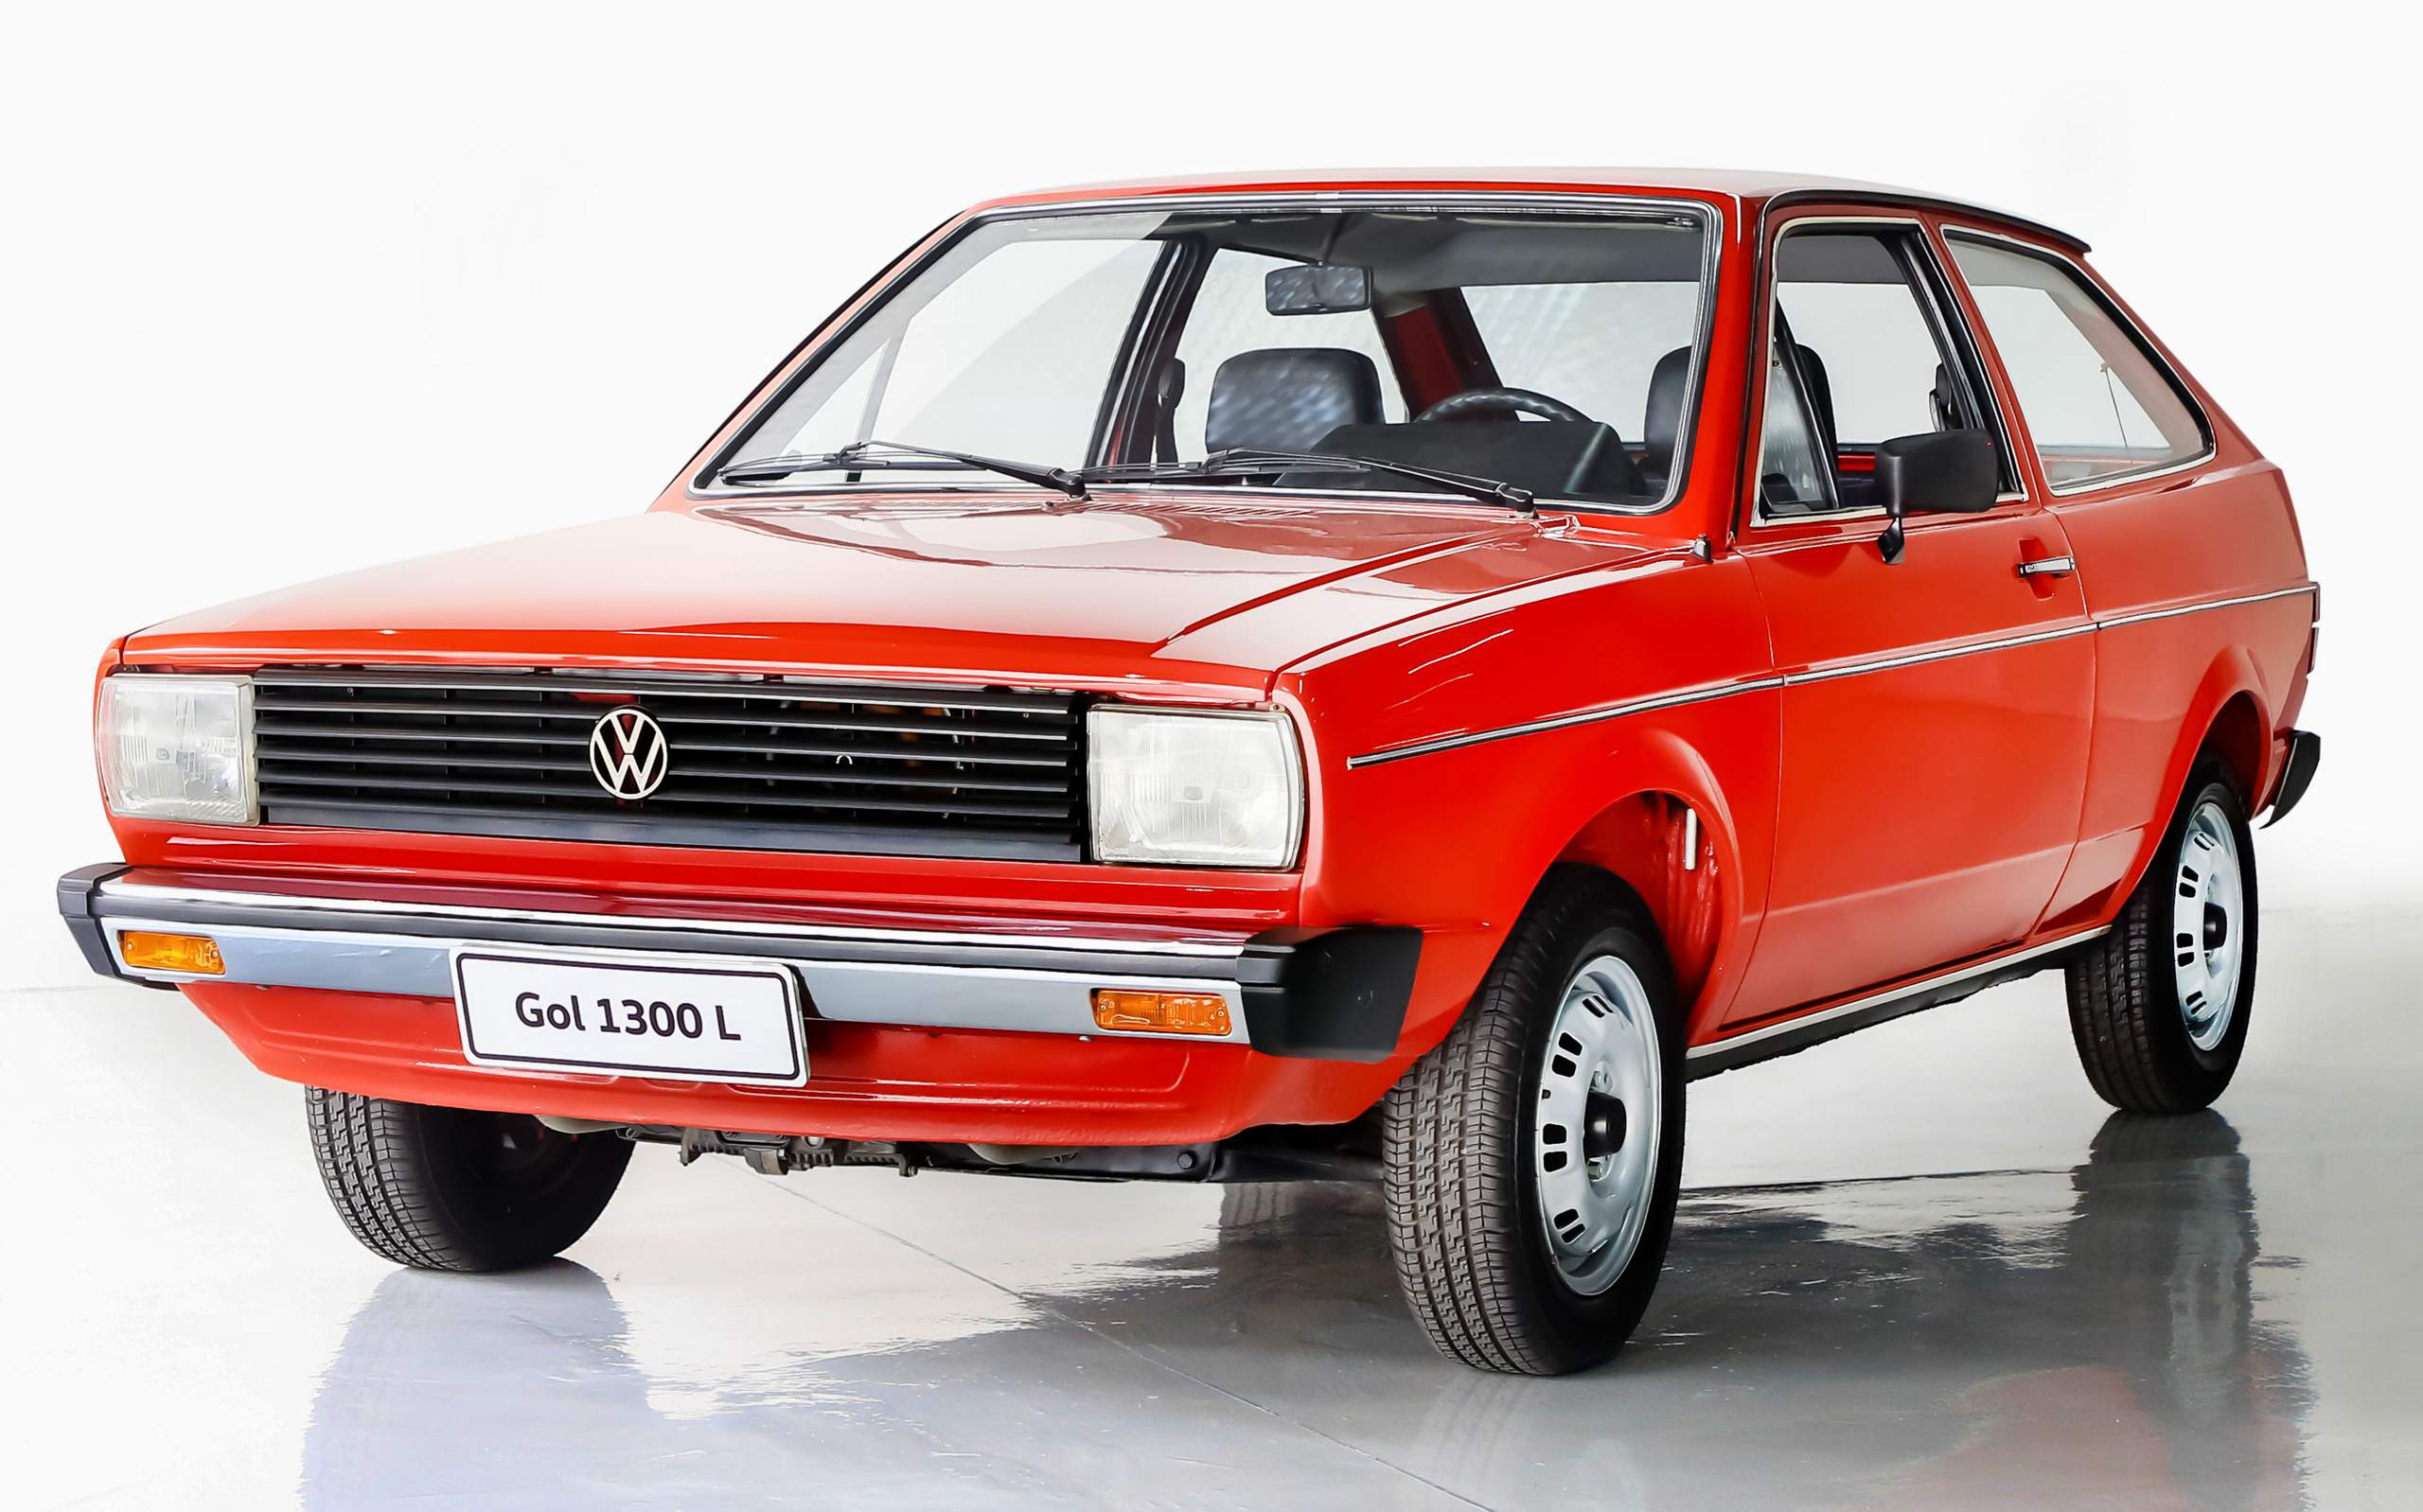

In [ ]:
LARGURA_ENTRADA =  640
ALTURA_ENTRADA = 640

img = io.imread('/content/drive/MyDrive/images/TESTE/VW-Gol-G1-1980.png.jpg')

fig = px.imshow(img)
fig.update_layout(width=700, height=400, margin=dict(l=10, r=10, b=10, t=10))
fig.update_xaxes(showticklabels=False).update_yaxes(showticklabels=False)
fig.show()


# Carregando modelo treinado
net = cv2.dnn.readNet('./yolov5/runs/train/Model2/weights/best.onnx')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

Funções para obter a confiança e a detecção

In [ ]:
def get_detections(img,net):
    # 1.Converte a imagem para o formato que o YOLO aceita
    image = img.copy()
    row, col, d = image.shape

    max_rc = max(row,col)
    input_image = np.zeros((max_rc,max_rc,3),dtype=np.uint8)
    input_image[0:row,0:col] = image

    # 2. Retorna a predição do modelo do YOLO
    blob = cv2.dnn.blobFromImage(input_image,1/255,(LARGURA_ENTRADA,ALTURA_ENTRADA),swapRB=True,crop=False)
    net.setInput(blob)
    preds = net.forward()
    detections = preds[0]
    
    return input_image, detections

def non_maximum_supression(input_image,detections):
    
    # 3. Filtra as detecções baseada nas confianças e pontuação de probabilidade
    
    # center x, center y, w , h, conf, proba
    boxes = []
    confidences = []

    image_w, image_h = input_image.shape[:2]
    x_factor = image_w/LARGURA_ENTRADA
    y_factor = image_h/ALTURA_ENTRADA

    for i in range(len(detections)):
        row = detections[i]
        confidence = row[4] # Confiança das detecções de placas
        if confidence > 0.4:
            class_score = row[5] # Pontuação de probabilidade 
            if class_score > 0.25:
                cx, cy , w, h = row[0:4]

                left = int((cx - 0.5*w)*x_factor)
                top = int((cy-0.5*h)*y_factor)
                width = int(w*x_factor)
                height = int(h*y_factor)
                box = np.array([left,top,width,height])

                confidences.append(confidence)
                boxes.append(box)

    # 4.1 CLEAN
    boxes_np = np.array(boxes).tolist()
    confidences_np = np.array(confidences).tolist()
    
    # 4.2 NMS
    index = cv2.dnn.NMSBoxes(boxes_np,confidences_np,0.25,0.45)
    
    return boxes_np, confidences_np, index

def drawings(image,boxes_np,confidences_np,index):
    # 5. Desenhos
    for ind in index:
        x,y,w,h =  boxes_np[ind]
        bb_conf = confidences_np[ind]
        conf_text = 'plate: {:.0f}%'.format(bb_conf*100)
        #license_text = extract_text(image,boxes_np[ind])


        cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,255),2)
        cv2.rectangle(image,(x,y-30),(x+w,y),(255,0,255),-1)
        cv2.rectangle(image,(x,y+h),(x+w,y+h+25),(0,0,0),-1)


        cv2.putText(image,conf_text,(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.7,(255,255,255),1)
        #cv2.putText(image,license_text,(x,y+h+27),cv2.FONT_HERSHEY_SIMPLEX,0.7,(0,255,0),1)

    return image

# Fluxo de predições com resultado
def yolo_predictions(img,net):
    # 1: Detecção
    input_image, detections = get_detections(img,net)
    # 2: Non_maximum_supression
    boxes_np, confidences_np, index = non_maximum_supression(input_image, detections)
    # 3: Desenhos
    result_img = drawings(img,boxes_np,confidences_np,index)
    return result_img    

Teste abaixo:


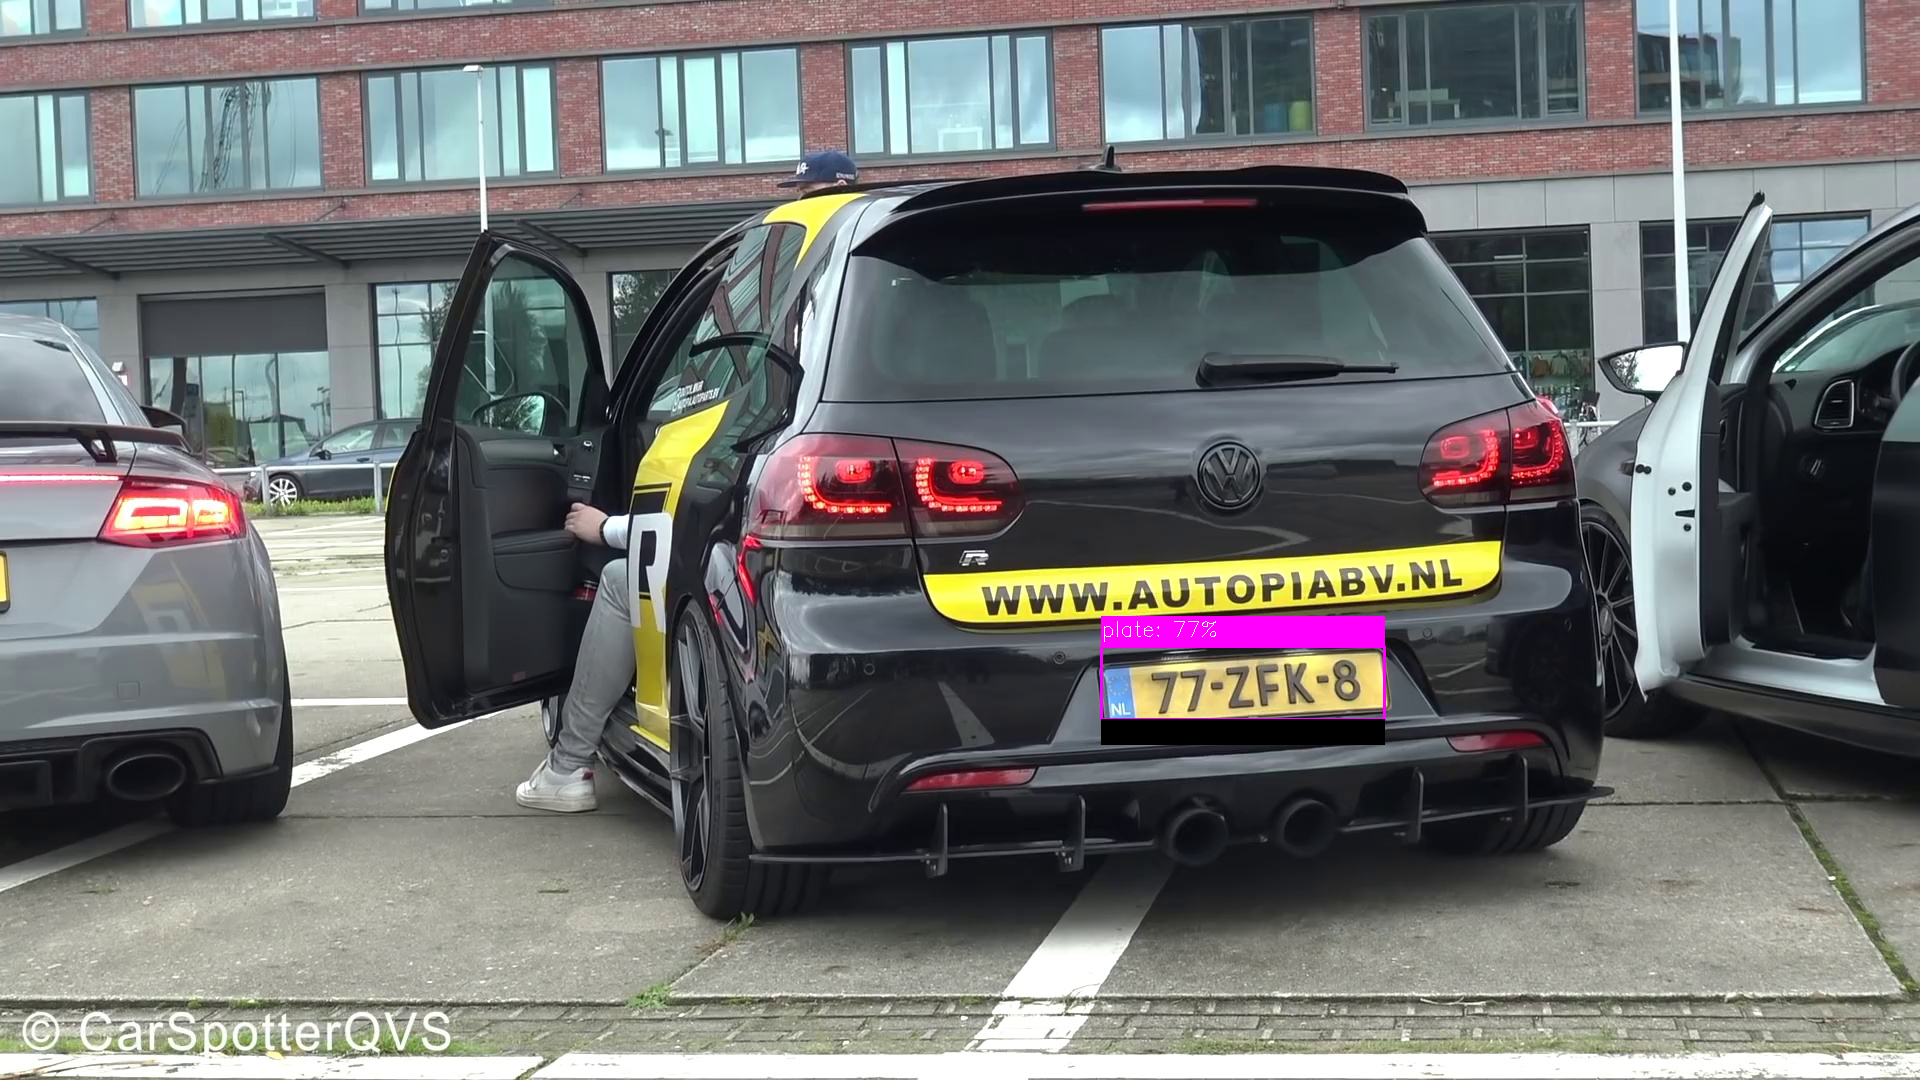

In [ ]:
img = io.imread('/content/drive/MyDrive/images/TESTE/VW-Gol-G1-1980.png.jpg')
results = yolo_predictions(img,net)

fig = px.imshow(img)
fig.update_layout(width=700, height=400, margin=dict(l=10, r=10, b=10, t=10))
fig.update_xaxes(showticklabels=False).update_yaxes(showticklabels=False)
fig.show()